# Machine Learning
## Loading Data
We open our ML-ready dataset
* **inputs:** First we concatenated the title, subtitle and article labels. Then we tokenized & lemmatized individual words, and used Spacys large german model to look up embedding vectors for every token. Those vectors were originally generated using the word2vec algorithm, where the goal is to place words in a 300-dimensional space where words that are used in similar contexts have a smaller euclidean distance in the vector space. Then we average all word vectors for the tokens in our concatenated text, which for our short texts should roughly correspond to the overal position of the text in the 300-dimensional space expressed by the vector. To this we append the year, month and weekday as components of a normalized vector.
* **targets:** The targets correspond to 64 bins, each bin representing a range in the number of posts an article has generated. This was done in order to:
    1. Have our target variable be roughly evenly distributed, as the bins grow in size to mitigate the power-law distribution present in the actual values.
    2. Limit the range of values the neural network needs to predict.

    In effect, we have turned a regression problem into a classification, and then back into a regression again. This way we can still preserve the meaning if a prediction closely misses the correct bin, which lets the neural network adjust more precisely than in a classification where this distance information would be lost.

In [1]:
import pandas as pd

df = pd.read_parquet('data/ml_data.parquet') # requires pyarrow
df.head()


,inputs,target,n_posts
0,"[0.45066947, 0.22533473, 0.8637831, -0.3755263...",18,30
1,"[0.4656903, 0.23284516, 0.8537656, -0.08075753...",12,16
2,"[0.48154342, 0.24077171, 0.84270096, 0.6938566...",34,104
3,"[0.48154342, 0.24077171, 0.84270096, -0.149591...",20,35
4,"[0.49827287, 0.24913643, 0.8304548, -0.0210107...",3,4


## Loading df into torch, train test split
Now we start using pytorch. I was able to finally play with cuda on my trusty old gtx970, but this code should be agnostic to the type of device.

In the following cell, we create tensors for our inputs and target values, and combine them into a tensor dataset, on which we perform an 80/20 test split.
We chose batch size 64, meaning 64 datapoints are pushed to the gpu in one training run. This value utilizes my gpu slightly more (cuda usage according to task manager at 40%), while at the same time hopefully not beeing too large to cause overfitting. The train and test loader objects will be responsible for pushing the data to the gpu.

In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# Using cuda
my_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using ', my_device)

# Create a TensorDataset
inputs = torch.tensor(df['inputs'].tolist(), device=my_device)
targets = torch.tensor(df['target'].values, device=my_device)
dataset = TensorDataset(inputs, targets)

# Split into training and test set
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


We are using  cuda


C:\Users\Paul\AppData\Local\Temp\ipykernel_12152\2500532675.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  inputs = torch.tensor(df['inputs'].tolist(), device=my_device)


## Model definitions
### Deep regression network
Here we define our regression neural network. It takes as an argument the layer sizes and generates `len(layers_sizes)` layers. Furthermore we also add a dropout probability, meaning that during training, with a set probability, a neurons output will randomly be ignored, meaning its output will not be fed as input to the next layer. This pruning technique should hopefully make our model more robust to overfitting as the model should not become overly reliant on single neurons or pathways through the network, encouraging a more distributed and robust internal representation.

As activation functions, we use the nonlinear ReLu function, which worked decently in our testing.

The output layer consists of a single neuron, which should predict values in the range 0-63. We do not perform activation on this final output as to not squash its output.

In [3]:
import torch.nn as nn
import torch.nn.functional as F


class RegressionNN(nn.Module):
    def __init__(self, drop, layer_sizes):
        super(RegressionNN, self).__init__()

        # Create layers dynamically
        self.layers = nn.ModuleList()
        for i in range(len(layer_sizes)-1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))

        self.dropout = nn.Dropout(drop)

        self.output_layer = nn.Linear(layer_sizes[-1], 1)

    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
            x = self.dropout(x)

        x = self.output_layer(x)
        return x


## Training loop
Here we define the training loop, which takes as parameters the number of epochs and learning rate. An evaluation criterion can optionally be specified but we decided to go with the standard mean-squared-error approach as it is a staple in regression problems and maps well to our intention of minimizing the error of our predictions.

In [4]:
import torch
import torch.optim as optim
from tqdm import tqdm

def train(model, epochs, learning_rate, criterion=nn.MSELoss()):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = []
    for epoch in tqdm(range(epochs)):
        model.train()
        total_loss = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(my_device), targets.to(my_device)
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs.squeeze(), targets.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        epoch_loss = total_loss/len(train_loader)
        losses.append(epoch_loss)
    return losses


## Evaluation
### On test set
This function will print the average mean squared error among all batches of the training set (20% of our data).

In [5]:
def eval_on_test(model, criterion=nn.MSELoss()):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(my_device), targets.to(my_device)
            outputs = model(inputs.float())
            loss = criterion(outputs.squeeze(), targets.float())
            test_loss += loss.item()
    print(f"Test Loss: {test_loss/len(test_loader)}")


### Plotting the loss curve
This function simply plots the loss as a function of the number of epochs during training, allowing us to monitor our training efficiency and check once the model stops improving.

In [6]:
import matplotlib.pyplot as plt

def plot_losses(losses):
    # Plot the losses
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.show()


### Testing on the current frontpage
Finally, we thought it would be interesting to fetch a given day's actual frontpage and see how our model would fare.

For this, 4 functions are defined:
* `get_final_articles_df():` Unfortunately I found no good way to import functions from other notebooks as you would normally do with python modules. Thus this method violates DRY and is a copy-paste of everything needed from the scraping and processing notebook to return a dataframe of a given day's frontpage, along with processing the text into a vector.
* `plot_preds():` This plots our predicted bounds as a bar, along with the actual values as a red line, sorted in ascending order of actual number of posts.
* `print_preds():` This prints all the articles that were within our predicted bounds, as well as the two articles furthest away from our prediction.
* `compare_prediction_for_date():`This is just a wrapper for the above three functions, which takes a model as well as a date as parameters.

In [7]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from functools import cache
import numpy as np
import requests
import spacy

@cache # We cache the results of this function to avoid fetching the same data multiple times
def get_final_articles_df(date):
    link = f'https://www.derstandard.at/frontpage/{date.strftime('%Y/%m/%d')}'
    # fetch the html content of a derstandard.at page
    response = requests.get(link, cookies={'DSGVO_ZUSAGE_V1': 'true'})
    soup = BeautifulSoup(response.content, 'html.parser')
    # get the articles
    articles_dict = {}
    articles = soup.select('div.chronological>section article')
    for article in articles:
        title_tag = article.find('a')
        if title_tag and title_tag.has_attr('title'):
            title = title_tag['title']
            articles_dict[title] = article
    # make a list of the articles
    HOST = 'https://www.derstandard.at'
    article_data = []
    for title, article in articles_dict.items():
        data = {
            'title': title,
            'teaser-subtitle': None,
            'link': None,
            'time': None,
            'teaser-kicker': None,
            'n_posts': None,
            'storylabels': None
        }
        link = article.find('a')['href']
        if not link.startswith(HOST):
            link = HOST + link
        data['link'] = link
        time = [tag for tag in article.find_all('time') if 'datetime' in tag.attrs][0]
        data['time'] = time['datetime'].rstrip('\r\n')
        n_posts = article.find('div', 'teaser-postingcount')
        try: data['n_posts'] = int(n_posts.get_text(strip=True).rstrip('Posting').replace('.', ''))
        except: data['n_posts'] = 0
        for tag, class_name in [('p', 'teaser-kicker'), 
                                ('p', 'teaser-subtitle'), 
                                ('div', 'storylabels')]:
            found_tag = article.find(tag, class_=class_name)
            if found_tag:
                data[class_name] = found_tag.get_text(strip=True)
        article_data.append(data)
    # make a df
    df = pd.DataFrame(article_data)
    df.columns = df.columns.str.replace('teaser-', '')
    df.rename(columns={'time': 'datetime'}, inplace=True)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['text'] = df['title'] + ' ' + df['kicker'].fillna('') + ' ' + df['subtitle'].fillna('')
    # add embeddings
    nlp = spacy.load("de_core_news_lg")
    df['doc_vector'] = df['text'].apply(lambda t: nlp(t).vector)
    # add date
    def process_row(row):
        date_vector = np.array([
            row['datetime'].month,
            row['datetime'].weekday(),
            row['datetime'].hour
            ])
        # Normalize the date_vector, ensure it is float32 like the doc vectors
        norm_date_vector = (date_vector / np.linalg.norm(date_vector)).astype(np.float32)
        return np.concatenate((norm_date_vector, row['doc_vector']))
    df['inputs'] = df.apply(process_row, axis=1)
    return df


def plot_preds(preds):
    # Create a copy of preds and sort by actual value
    preds_copy = sorted(preds, key=lambda x: x[0])
    actual, lower_bound, upper_bound = zip(*preds_copy)
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(actual, color='red', label='Actual')
    plt.fill_between(range(len(actual)), lower_bound, upper_bound, color='grey', alpha=0.5, label='Predicted')
    plt.xlabel('Articles')
    plt.ylabel('number of posts')
    plt.title('Actual vs Predicted')
    plt.legend()
    plt.show()


def print_preds(preds, articles):
    within_bounds, outside_bounds = [], []
    for i, (act, lower, upper) in enumerate(preds):
        if lower <= act < upper: # upper bound is exclusive
            within_bounds.append(i)
        else:
            distance = min(abs(act - lower), abs(act - upper))
            outside_bounds.append((i, distance))
    # Sort the outside_bounds list by distance in descending order and get the first two indices
    furthest_indices = [i for i, _ in sorted(outside_bounds, key=lambda x: x[1], reverse=True)[:2]]
    # Fetch the rows from the articles DataFrame for within_bounds
    def print_in_color(indices, articles, preds, prediction_type):
        for i in indices:
            row = articles.iloc[i]
            print(f"{prediction_type} Prediction: {row['text']}")
            print(f"Number of Posts: {row['n_posts']}")
            print(f"Predicted Bounds: ({preds[i][1]}, {preds[i][2]}]")
            print(f"Link: {row['link']}\n")
    # Print the correct predictions in green
    print("\033[92m")
    print_in_color(within_bounds, articles, preds, "Correct")
    # Print the incorrect predictions in red
    print("\033[91m")
    print_in_color(furthest_indices, articles, preds, "Incorrect")
    # Reset the color back to normal
    print("\033[0m")


@cache
def compare_prediction_for_date(model, date):
    # fetch articles for the date
    articles = get_final_articles_df(date)
    target_map = pd.read_csv('data/target_map.csv')
    predicted = [] # list of tuples (actual, pred_lower_bound, pred_upper_bound, row)
    for i, row in articles.iterrows():
        input_data = torch.tensor(row['inputs'], dtype=torch.float)
        input_data = input_data.to(next(model.parameters()).device)
        # Reshape the input data and pass it through the model
        input_data = input_data.unsqueeze(0)  # Add a batch dimension
        with torch.no_grad():
            output = model(input_data)
        target_index = min(int(output.item()), 63) # ensure we don't go out of bounds
        tm = target_map.iloc[target_index]
        predicted.append((row['n_posts'], tm.lower_b, tm.upper_b))
    plot_preds(predicted)
    print_preds(predicted, articles)
    


### Wrapping it all into a single function
And lastly, one function to wrap all the evaluations into one.

In [8]:
def eval_trained_model(model, losses, date):
    plot_losses(losses)
    eval_on_test(model)
    compare_prediction_for_date(model, date)

## Testing different models
We will be testing regression models of different sizes. For our evaluations of a particular frontpage, we picked a frontpage that is a week old (31.12.23), giving the articles enough time to gather posts (as in our training data).

In [9]:
# pick test date one week ago
test_date = datetime.now() - timedelta(days=7)

### Small regression Model
First is a small-ish Regression network.
* `drop = 0.3`, as we found that higher dropout values took extremely long to converge and did not really help with the overfifting problem. Our training loss was always around 20% higher than our test-set loss.
* `layer_sizes = [303, 128, 64]`. The idea here is to create a sort of information funnel, where each layer should hopefully pick up on higher-level features in the data, with fewer neurons being responsible for aggregating information from the previous layer. If I were to fantasize what those higher-level-features could be - the 300-dimensional position of the text could represent the overall sentiment, picked up by higher layers? But really we have no idea how the network interprets those vectors. The idea behind having 64 neurons is to have one neuron per bucket- each one maybe contributing `1` to the final output neuron. But again we are speculating, let's see how it performs.

training small model


100%|██████████| 500/500 [1:02:39<00:00,  7.52s/it]


evaluating small model


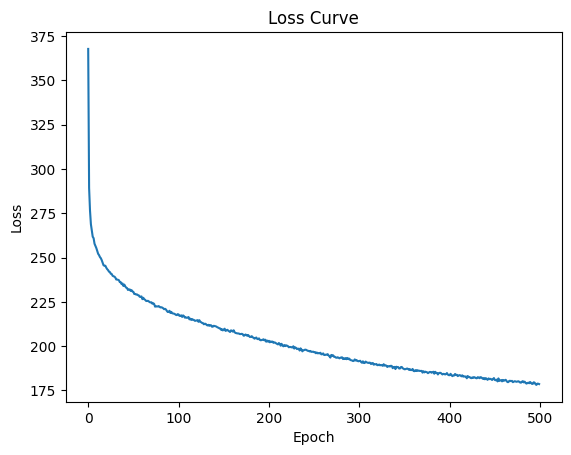

Test Loss: 217.58059333828228


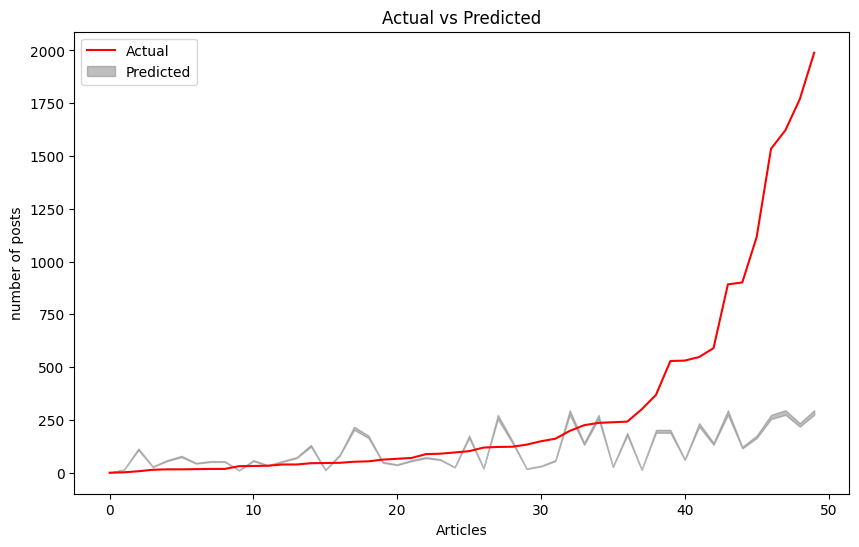


Correct Prediction: Web- und Games-News: Gebrauchtwagen-Besitzer könnten bald Abogebühren bezahlen Nachrichtenüberblick Das sind die aktuellen Schlagzeilen aus Web und Games
Number of Posts: 0
Predicted Bounds: (0, 1]
Link: https://www.derstandard.at/story/3000000201431/web-und-games-news-gebrauchtwagen-und-abo

Correct Prediction: Das Universum als Perspektivgeber Feelgood Manchmal hilft es, Dinge in Relation zu setzen – vom kleinsten Teilchen bis zum galaktischen Supercluster
Number of Posts: 33
Predicted Bounds: (33, 36]
Link: https://www.derstandard.at/story/3000000200558/das-universum-als-perspektivgeber


Incorrect Prediction: Klimawandel, Rechtsruck, Inflation: Die Sorgen der Jungen steigen weiter Zukunftsängste Serienweise Krisen, permanenterLeistungsdruck,das Streben nach Besonderem und der ständige Vergleich über soziale Medien belasten junge Menschen zunehmend. Unbeschwert fühlen sich nur wenige. Aber es gibt auch Grund für Optimismus
Number of Posts: 1989
Predicted Bounds:

In [10]:
small_model = RegressionNN(
    drop = 0.3,
    layer_sizes = [303, 128, 64]
    ).to(my_device)

print('training small model')
small_losses = train(small_model, epochs=500, learning_rate=0.0001)
print('evaluating small model')
eval_trained_model(small_model, small_losses, test_date)

I am actually kind of happy with this result. Of course the mean squared error of 217 on the test set is not particularly amazing (seeing as our values only have a range of 64), but the loss curve indicates that the model was actually able to learn some things about the data and was not just randomly guessing. It seems like there is some gradient in the vector space that can be learned.

Furthermore, the plot of articles on (31.12.23) shows us that our bar of predictions is actually pretty slim. With fewer than 64 buckets (maybe only 10), the predictions would probably hit the correct neighborhood more often. The problem here remains the distribution of posts. I have experimented with a smaller number of buckets, but as the vast majority of articles generates between 0 and 10 posts (as indicated by those buckets not actually being buckets but discrete values) - these low values would still overrepresented in the data and the cutoff to articles with higher post counts would be extremely early. The only alternative here would be to actually drop a lot of values from our test set - which is something that could be tested with more time.

Maybe dropping the majority of low-postcount observations would also help with the overall performance of the model as the current distribution of observations might be lead the regression to trend lower than it should - as seen by the lineplot where the actual number of posts (red) trends much higher than the predictions past around ~250 posts.

### Medium regression Model 'with a slimmer funnel'
For the next experiment, we will append two final layers with 32 and 16 neurons respectively. Maybe the regression will work better with a longer funnel. To switch things up, we will be testing it on articles from (30.12.23)

training medium model


100%|██████████| 500/500 [1:03:27<00:00,  7.61s/it]


evaluating medium model


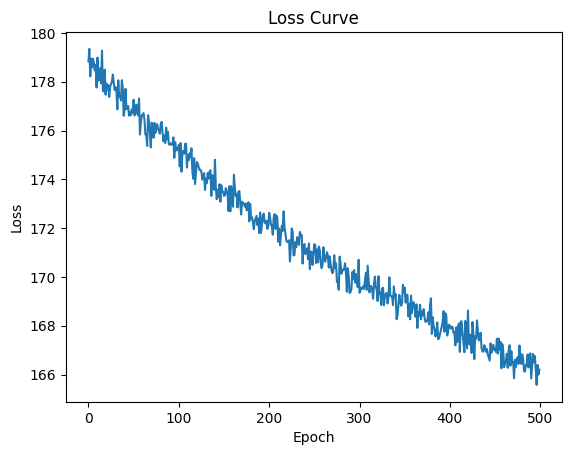

Test Loss: 220.54502462919524


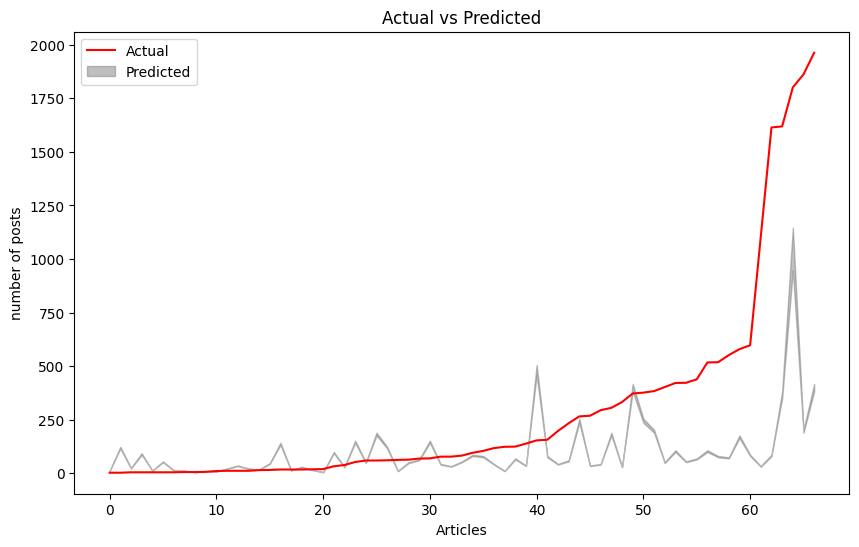



Incorrect Prediction: Signa-Kollaps: Gusenbauer tritt als Millionen-Gläubiger auf Wirtschaft Laut Recherchen von "Profil" und der "Süddeutschen Zeitung" hat der Ex-Kanzler Alfred Gusenbauer (SPÖ) Forderungen in Höhe von mehr als 6,3 Millionen Euro eingebracht
Number of Posts: 1862
Predicted Bounds: (189, 203]
Link: https://www.derstandard.at/story/3000000201381/signa-kollaps-chef-der-finanzprokuratur-sorgt-sich-um-staatsgeld

Incorrect Prediction: Frauen werden gleichgestellt, aber nicht gleich behandelt Petra Stuiber 2024 beginnt die Anpassung des Pensionsalters an das der Männer. Sonst aber bleibt alles beim Alten
Number of Posts: 1963
Predicted Bounds: (382, 417]
Link: https://www.derstandard.at/story/3000000201355/frauen-werden-gleichgestellt-aber-nicht-gleich-behandelt




In [11]:
medium_model = RegressionNN(
    drop = 0.3,
    layer_sizes = [303, 128, 64, 32, 16]
    ).to(my_device)

print('training medium model')
medium_losses = train(small_model, epochs=500, learning_rate=0.0001)
print('evaluating medium model')
eval_trained_model(small_model, medium_losses, test_date-timedelta(days=1))

Once more we need to accept that bigger is not necessarily better. In this case, extending our network by two smaller layers has not improved our test set performance at all, it is pretty much on par with the small model. Furthermore, for the 30.12., the model was not able to correctly categorize a single article :(

What is remarkable though is how different the loss curve looks this time. Instead of approaching some limit in a logarithmic fashion, the loss (on the training set) seems to decrease linearly. Also the loss starts at a much lower value, probably we just got lucky with the initialization of our weights. Normally this linear decrease should be a good sign that our model has still not found an optimum, but the test-set performance indicates that we were probably just overfitting to the training data (hard to call it overfitting with such a high loss).

We won't be discouraged by this, lets go one step bigger and make an even deeper network before we call it quits. This time we will still keep 64 neurons for the second-to-last layer.

### Big regression Model
8 hidden layers, decreasing in size. With more parameters, I have decided to increase the dropout probability to 40%, decrease the learning rate by a decimal place and train for 1.000 epochs.

training big model


100%|██████████| 1000/1000 [3:18:36<00:00, 11.92s/it] 

evaluating big model


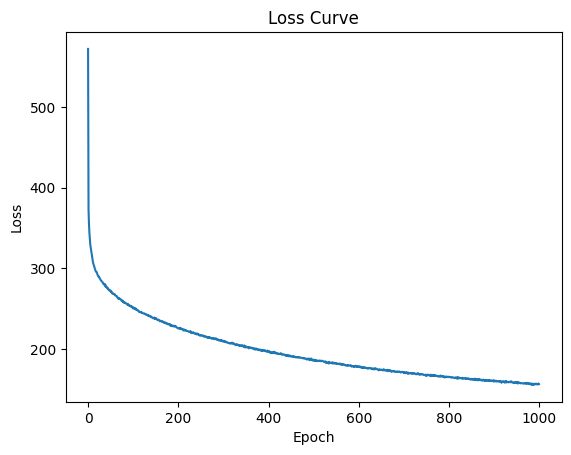

Test Loss: 267.1881389280933


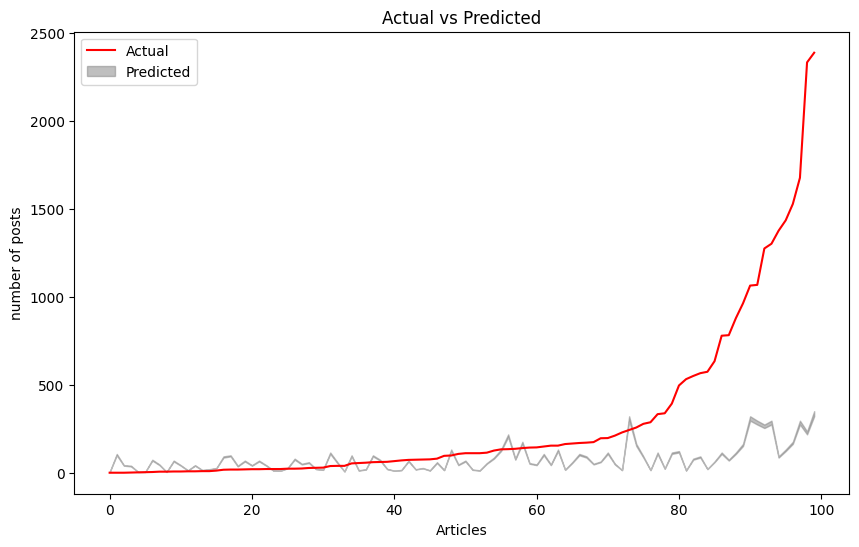



Incorrect Prediction: Bereits 31 Tote nach massiver Angriffswelle auf die Ukraine Krieg in der Ukraine Unter anderem wurden die Städte Kiew, Charkiw, Dnipro, Lwiw und Odessa angegriffen. Die EU beteuerte trotz ungarischen Widerstands ihre Unterstützung
Number of Posts: 2333
Predicted Bounds: (218, 235]
Link: https://www.derstandard.at/jetzt/livebericht/3000000201236/russische-angriffe-auf-staedte-charkiw-und-lwiw

Incorrect Prediction: Gegen Woke und Wärmepumpen: Monika Gruber wettert in Büchern – und auf Demos Ausweitung der Kampfzone Eine Bloggerin fühlt sich von Passagen des neuen Buches des Kabarett-Stars rassistisch beleidigt. Die Bayerin wettert auch auf Bühnen gegen grünen, woken Fortschritt
Number of Posts: 2388
Predicted Bounds: (321, 350]
Link: https://www.derstandard.at/story/3000000201329/gegen-woke-und-waermepumpen-monika-gruber-wettert-in-buechern--und-auf-demos




In [12]:
big_model = RegressionNN(
    drop = 0.4,
    layer_sizes = [303, 303, 256, 256, 256, 128, 128, 64]
    ).to(my_device)

print('training big model')
big_losses = train(big_model, epochs=1000, learning_rate=0.00001)
print('evaluating big model')
eval_trained_model(big_model, big_losses, test_date-timedelta(days=2))

Even worse performance than the medium model on the test set. I have a feeling that the vector representation does not capture the message content well enough.

We will perform one last experiment. Scaling our neural networks hidden layers to be wider than the input.

### Wide regression Model
Here we go both wide and deep. This model should have over 3 million parameters. Because the last run was overfitting so terribly, I decided to only train this network for 600 epochs, with the same learning rate as before and increased dropout to 50%.

training wide model


100%|██████████| 600/600 [2:49:28<00:00, 16.95s/it]  


evaluating wide model


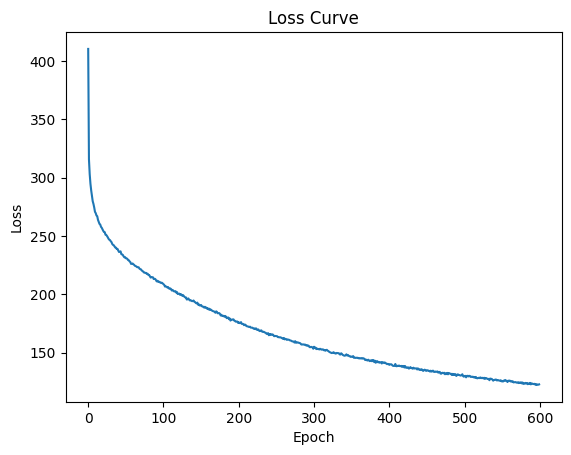

Test Loss: 496.87058120565786


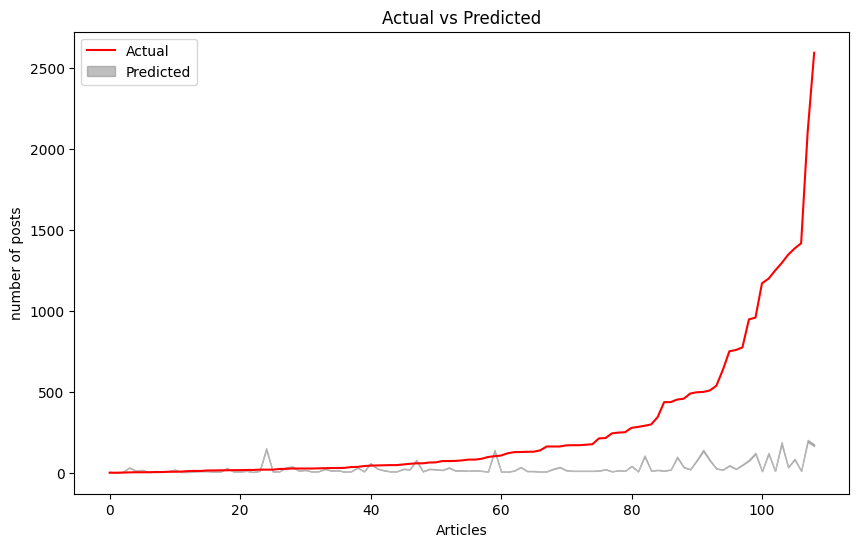


Correct Prediction: Web- und Games-News: Ein Onlyfans-Model gegen die NASA Nachrichtenüberblick Das sind die aktuellen Schlagzeilen aus Web und Games
Number of Posts: 0
Predicted Bounds: (0, 1]
Link: https://www.derstandard.at/story/3000000201208/web-und-games-news-das-comeback-eines-baby-ichhoernchens

Correct Prediction: Kreuzworträtsel I 10574 Kreuzworträtsel Täglich neu, exklusiv fürSmart-Abonnent:innen:Das kniffligephoenixen-Rätseldes STANDARD
Number of Posts: 3
Predicted Bounds: (3, 4]
Link: https://www.derstandard.at/story/3000000200358/kreuzwortraetsel-i-10574


Incorrect Prediction: Deutschland sichert Ukraine weitere EU-Finanzhilfe zu Krieg in der Ukraine Russland hat ukrainischen Angaben zufolge das Land in der Nacht erneut mit Drohnen angegriffen. Zwei russische Dichter erhielten wegen kritischen Gedichts zum Ukrainekrieg lange Haftstrafen
Number of Posts: 2594
Predicted Bounds: (164, 176]
Link: https://www.derstandard.at/jetzt/livebericht/3000000201130/erneut-nacht-drohne

In [13]:
wide_model = RegressionNN(
    drop = 0.5,
    layer_sizes = [303, 606, 909, 909, 909, 606, 303]
    ).to(my_device)

print('training wide model')
wide_losses = train(wide_model, epochs=600, learning_rate=0.00001)
print('evaluating wide model')
eval_trained_model(wide_model, wide_losses, test_date-timedelta(days=3))

A test set loss that is almost 2.5x that of the small model. Not very promising signs to just scale the network.

## Conclusion
There may be countless reasons why this project was not successful in reliably predicting post counts.

In all fairness, I think this is a really difficult problem. Ultimately it should be impossible to predict how many people will open a given article and feel compelled to add their 5 cents to the discussion. However as Isaac Asimov's psychohistory postulates: *'the laws of statistics as applied to large groups of people could predict the general flow of future events'*, so we decided to give it a shot anyways.

### Possible next steps
With even more time, I would try encoding the data differently. Maybe using an RNN architecture, feeding in embedding vectors one at a time. Or possibly instead of using Word2Vec, we could apply a transformer to get our embeddings for the whole set.

Perhaps traditional machine learning techniques could also work, maybe a simple clustering of the current vectors.

I am sceptical that simply changing the activation functions would do much, I experimented a bit with leaky ReLu but found no improvements.

As already mentioned, maybe filtering the data would prevent the network from trending so low for all posts.

### Saving the 'best' model
To finish things up, we save the network that was most successful on the test data - the small model. It will also be available for download in the [onedrive link](https://1drv.ms/f/s!As0d2mVTvxe4hoY_MrtNVk6EieX4OA?e=TuhIek)

In [18]:
torch.save(small_model.state_dict(), 'data/small_model.pth')